In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from slices import display_multi_slices, get_sdf_image
from tqdm.auto import tqdm
from synthetic_data import sphere_data, square_data
from marching_squares import get_img_marching_squares, display_multiple_shapes_sdf

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device="cpu"
device
from src.models.Sirenlayer import SirenNet
from src.optimize import optimize_nise_vf
from src.results.display import display_result,display_loss
device

In [ ]:
pc0, nc0, pts_hints0, gt_sdf_hints0, gt_grad_hints0, coords, sdf_coords = sphere_data(
    10000, 100000
)

# constant vector field (a single vector)
vf = torch.tensor([0.3, 0.0], device=device)


fig, axs = plt.subplots(1, 3, figsize=(8, 15))
pc_numpy = pc0.detach().cpu().numpy()
axs[0].scatter(pc_numpy[::100, 0], pc_numpy[::100, 1])
axs[0].set_aspect(1.0 / axs[0].get_data_ratio(), adjustable="box")
axs[0].set_xlim([-1, 1])
axs[0].set_ylim([-1, 1])
axs[0].set_title("Sphere points")
sdf_numpy = sdf_coords.detach().cpu().numpy()
axs[1].imshow(get_sdf_image(sdf_numpy))
axs[1].contour(sdf_numpy, 10, colors="k", linewidths=0.4, linestyles="solid")
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title("Ground truth SDF")
print(sdf_numpy.shape)
rec_img = get_img_marching_squares(sdf_numpy)
axs[2].imshow(rec_img)
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title("Reconstructed shape")


plt.tight_layout()
plt.show()

In [ ]:

#! with some help  
from src.models.tiny_cu import SDF_TCNN  
npl = 128
depth = 3
true_net = SDF_TCNN().to(device)
optimizer = lambda model: torch.optim.Adam([
            {'name': 'encoding', 'params': model.encoder.parameters()},
            {'name': 'net', 'params': model.backbone.parameters(), 'weight_decay': 1e-6},
        ], lr=1e-4, betas=(0.9, 0.99), eps=1e-15)
optimizer = optimizer(true_net)
lpc, leik, lh, llse = [], [], [], []
lemd=[]
lgc=[]  

batch_size=2000,
list_loss={"emd":[],"gc":[],"eik":[],"hint":[],"pc":[]}
pc_t0 = pc0.clone().to(device)
pts_hintst0 = pts_hints0.clone().to(device)
# nepochs = 10000
nepochs=5000
pc_t0.requires_grad = True
# nepochs=10
optimize_nise_vf(
    net=true_net,
    pc0=pc_t0,
    # nc0=nc0,
    hints0=pts_hintst0,
    gtsdf0=gt_sdf_hints0,
    # vf=vf,
    # lpc=lpc,
    # leik=leik,
    # lh=lh,
    # llse=llse,
    # lemd=lemd,
    # lgc=lgc,
    
    lambda_pc=1,# 
    lambda_eik=0.001, # eikonal,
    lambda_hint=0, #0.01, # used but need ground truth,
    lambda_lse=0, # not used,
    lambda_gc=0.01, #geometric consistency,
    lambda_emd=0, # lambda EMD,
    batch_size=2000,
    nepochs=nepochs,
    plot_loss=True,
    follow_paper=False,
    list_loss=list_loss,
    optim=optimizer
)
# save it 
torch.save(true_net, "net_vf_128_3.net")
display_result(true_net, resolution=200, figsize=(14, 5),title="Final result")
display_loss(list_loss,["pc"])

In [ ]:
def add_noise(pc0,sigma=0.01):
    # add random noise to the point cloud
    noise = torch.randn_like(pc0) * sigma
    return pc0 + noise

def add_noise_along_circle(pc0,scale=0.01):
    # add unfirom noise along the circle
    noise= torch.rand_like(pc0)*scale
    return pc0 + pc0*noise

# Hyperparameters search with the nb of data

In [ ]:

#! with some help  
from src.models.tiny_cu import SDF_TCNN  
nb_data=100
noise=0.01
for nb_data in [10,50,100,1000,10000]:
    noise=0



    true_net = SDF_TCNN().to(device)
    optimizer = lambda model: torch.optim.Adam([
                {'name': 'encoding', 'params': model.encoder.parameters()},
                {'name': 'net', 'params': model.backbone.parameters(), 'weight_decay': 1e-6},
            ], lr=1e-4, betas=(0.9, 0.99), eps=1e-15)

    pc0, nc0, pts_hints0, gt_sdf_hints0, gt_grad_hints0, coords, sdf_coords = sphere_data(
        nb_data, nb_data #! was sth else before
    )

    optimizer = optimizer(true_net)
    lpc, leik, lh, llse = [], [], [], []
    lemd=[]
    lgc=[]  

    batch_size=2000,
    list_loss={"emd":[],"gc":[],"eik":[],"hint":[],"pc":[]}
    pc_t0 = pc0.clone().to(device)
    # pc_t0=add_noise(pc_t0,sigma=0.01)
    # pc_t0=add_noise_along_circle(pc_t0,scale=3)
    # plot the points
    plt.clf()
    plt.scatter(pc_t0.detach().cpu().numpy()[:, 0], pc_t0.detach().cpu().numpy()[:, 1])
    plt.title("Input {} points with noise {}".format(nb_data,noise))
    plt.savefig("input_{}_{}.png".format(noise,nb_data))
    plt.show()

    pts_hintst0 = pts_hints0.clone().to(device)
    # nepochs = 10000
    nepochs=10000
    pc_t0.requires_grad = True
    # nepochs=10
    optimize_nise_vf(
        net=true_net,
        pc0=pc_t0,
        # nc0=nc0,
        hints0=pts_hintst0,
        gtsdf0=gt_sdf_hints0,
        # vf=vf,
        # lpc=lpc,
        # leik=leik,
        # lh=lh,
        # llse=llse,
        # lemd=lemd,
        # lgc=lgc,
        
        lambda_pc=1,# 
        lambda_eik=0.001, # eikonal,
        lambda_hint=0, #0.01, # used but need ground truth,
        lambda_lse=0, # not used,
        lambda_gc=0.01, #geometric consistency,
        lambda_emd=0, # lambda EMD,
        batch_size=2000,
        nepochs=nepochs,
        plot_loss=False,
        follow_paper=False,
        list_loss=list_loss,
        optim=optimizer
    )
    # save it 
    # torch.save(true_net, "net_vf_128_3.net")
    plt.clf()
    filname= "result_L1_{}_{}.png".format(noise,nb_data)

    display_result(true_net, resolution=200, figsize=(14, 5),title="Final result with L1 loss with noise {} and {} points".format(noise,nb_data),filename=filname)
    plt.clf()
    display_loss(list_loss,["pc"])
    plt.title("Fial result with L1 loss with noise {} and {} points".format(noise,nb_data))
    plt.show()

In [ ]:

#! with some help  
from src.models.tiny_cu import SDF_TCNN  
nb_data=100
noise=0.01
for nb_data in [10,50,100,1000,10000]:
    noise=0



    true_net = SDF_TCNN().to(device)
    optimizer = lambda model: torch.optim.Adam([
                {'name': 'encoding', 'params': model.encoder.parameters()},
                {'name': 'net', 'params': model.backbone.parameters(), 'weight_decay': 1e-6},
            ], lr=1e-4, betas=(0.9, 0.99), eps=1e-15)

    pc0, nc0, pts_hints0, gt_sdf_hints0, gt_grad_hints0, coords, sdf_coords = sphere_data(
        nb_data, nb_data #! was sth else before
    )

    optimizer = optimizer(true_net)
    lpc, leik, lh, llse = [], [], [], []
    lemd=[]
    lgc=[]  

    batch_size=2000,
    list_loss={"emd":[],"gc":[],"eik":[],"hint":[],"pc":[]}
    pc_t0 = pc0.clone().to(device)
    # pc_t0=add_noise(pc_t0,sigma=0.01)
    # pc_t0=add_noise_along_circle(pc_t0,scale=3)
    # plot the points
    plt.clf()
    plt.scatter(pc_t0.detach().cpu().numpy()[:, 0], pc_t0.detach().cpu().numpy()[:, 1])
    plt.title("Input {} points with noise {}".format(nb_data,noise))
    plt.show()
    plt.savefig("input_{}_{}.png".format(noise,nb_data))

    pts_hintst0 = pts_hints0.clone().to(device)
    # nepochs = 10000
    nepochs=10000
    pc_t0.requires_grad = True
    # nepochs=10
    optimize_nise_vf(
        net=true_net,
        pc0=pc_t0,
        # nc0=nc0,
        hints0=pts_hintst0,
        gtsdf0=gt_sdf_hints0,
        # vf=vf,
        # lpc=lpc,
        # leik=leik,
        # lh=lh,
        # llse=llse,
        # lemd=lemd,
        # lgc=lgc,
        
        lambda_pc=0,# 
        lambda_eik=0.001, # eikonal,
        lambda_hint=0, #0.01, # used but need ground truth,
        lambda_lse=0, # not used,
        lambda_gc=0.01, #geometric consistency,
        lambda_emd=1, # lambda EMD,
        batch_size=2000,
        nepochs=nepochs,
        plot_loss=False,
        follow_paper=False,
        list_loss=list_loss,
        optim=optimizer
    )
    # save it 
    # torch.save(true_net, "net_vf_128_3.net")
    plt.clf()
    filname= "result_EMD_{}_{}.png".format(noise,nb_data)

    display_result(true_net, resolution=200, figsize=(14, 5),title="Final result with EMD loss with noise {} and {} points".format(noise,nb_data),filename=filname)
    plt.clf()
    display_loss(list_loss,["pc"])
    plt.title("Final result with EMD loss with noise {} and {} points".format(noise,nb_data))

    plt.show()

## Now compute for different type of noise


# Now different type of noise

initialisation Xavier True fix_init False


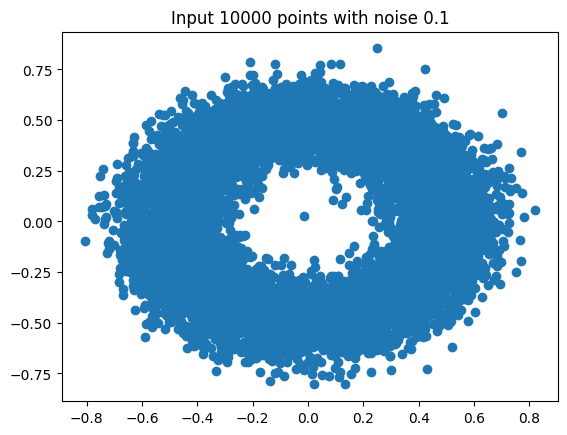

starting loss, lambda_pc=0, lambda_eik=0.001, lambda_hint=0, lambda_lse=0, lambda_gc=0.01, lambda_emd=1


lambda_pc is null


Training: 100%|██████████| 10000/10000 [06:08<00:00, 27.16it/s, loss=0.000501]


Optimizing NN took 368.16 s.
coords shape before adding t: torch.Size([40000, 2])
the sdf that will be displayed: tensor([[-0.5983],
        [-0.5907],
        [-0.5823],
        ...,
        [-0.5433],
        [-0.5484],
        [-0.5536]], device='cuda:0', grad_fn=<AddmmBackward0>)
keys emd [0.000251454534009099, 0.0002797151682898402, 0.00023537478409707546, 0.0003701855894178152, 0.00022597878705710173, 0.0002730049891397357, 0.00034048367524519563, 0.0002424065605737269, 0.00047461676876991987, 0.0004962365492247045, 0.0004806608194485307, 0.00023201166186481714, 0.0002952984650619328, 0.00039842733531259, 0.00022225678549148142, 0.0002234982093796134, 0.0003346719895489514, 0.0001781323371687904, 0.00043586886022239923, 0.0004176395887043327, 0.0002283104113303125, 0.0008245989447459579, 0.0007137061911635101, 0.00020074736676178873, 0.0002451246837154031, 0.00010942973312921822, 0.0002992801018990576, 0.00024381917319260538, 0.00023345364024862647, 0.0002411596360616386, 0.00042

<Figure size 640x480 with 0 Axes>

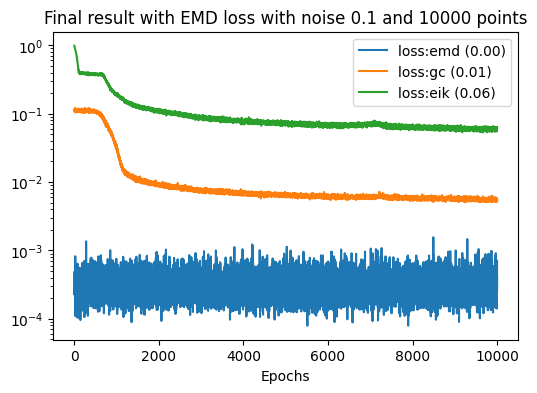

initialisation Xavier True fix_init False


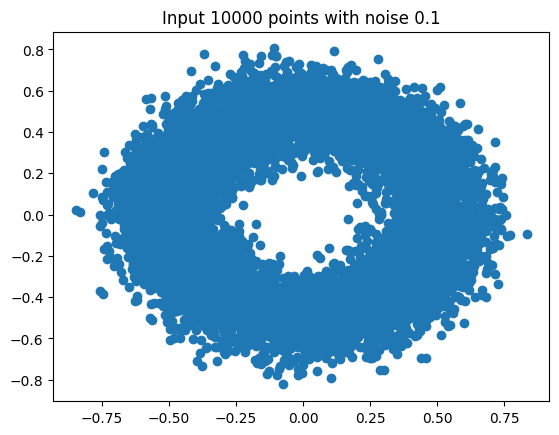

starting loss, lambda_pc=1, lambda_eik=0.001, lambda_hint=0, lambda_lse=0, lambda_gc=0.01, lambda_emd=0


lambda_emd is null


Training: 100%|██████████| 10000/10000 [01:55<00:00, 86.90it/s, loss=0.000139]


Optimizing NN took 115.07 s.
coords shape before adding t: torch.Size([40000, 2])
the sdf that will be displayed: tensor([[-0.6352],
        [-0.6282],
        [-0.6216],
        ...,
        [-0.6056],
        [-0.6132],
        [-0.6205]], device='cuda:0', grad_fn=<AddmmBackward0>)
keys gc [0.11047692596912384, 0.1200898140668869, 0.1110142394900322, 0.11107423156499863, 0.11342751979827881, 0.11525868624448776, 0.11218204349279404, 0.10764827579259872, 0.10984455049037933, 0.1157524362206459, 0.11319995671510696, 0.1119241714477539, 0.11228694021701813, 0.1087946817278862, 0.11400926858186722, 0.10955053567886353, 0.1141449585556984, 0.10759133100509644, 0.11131824553012848, 0.11233465373516083, 0.11356906592845917, 0.11471091210842133, 0.11603894829750061, 0.11483985930681229, 0.11332657188177109, 0.11460421979427338, 0.11071591824293137, 0.11098415404558182, 0.10965321958065033, 0.1089298278093338, 0.11024695634841919, 0.10950268805027008, 0.11506178975105286, 0.11072443425655365,

<Figure size 640x480 with 0 Axes>

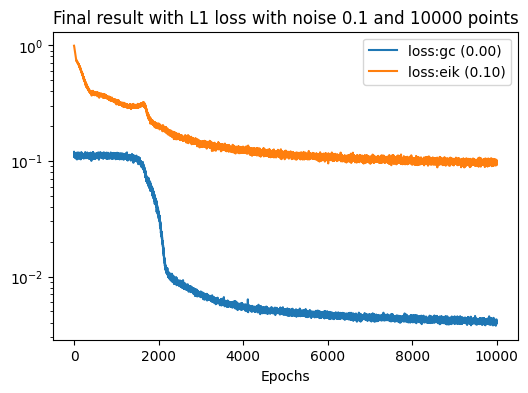

initialisation Xavier True fix_init False


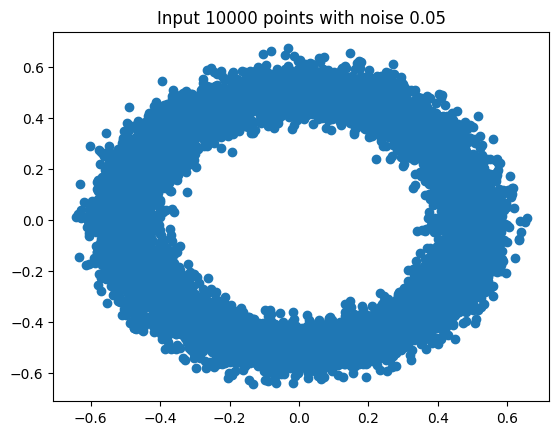

starting loss, lambda_pc=0, lambda_eik=0.001, lambda_hint=0, lambda_lse=0, lambda_gc=0.01, lambda_emd=1


lambda_pc is null


Training: 100%|██████████| 10000/10000 [06:07<00:00, 27.19it/s, loss=0.000778]


Optimizing NN took 367.81 s.
coords shape before adding t: torch.Size([40000, 2])
the sdf that will be displayed: tensor([[-0.8373],
        [-0.8297],
        [-0.8215],
        ...,
        [-0.8424],
        [-0.8498],
        [-0.8610]], device='cuda:0', grad_fn=<AddmmBackward0>)
keys emd [0.0006684376858174801, 0.00044254399836063385, 0.0002825988922268152, 0.0006286543793976307, 0.00025136303156614304, 0.0007639647228643298, 0.00029483967227861285, 0.00025793968234211206, 0.00026739557506516576, 0.0002414710761513561, 0.00017340632621198893, 0.00026381155475974083, 0.0001771721290424466, 0.0003999902110081166, 0.00040396442636847496, 0.00012083640467608348, 0.0001587614242453128, 0.0003133867576252669, 0.00035948320874013007, 0.0002183428150601685, 0.00020725137437693775, 0.0002229198580607772, 0.0002512888459023088, 0.0001696860563242808, 0.0001740369771141559, 8.449617598671466e-05, 0.0004689250490628183, 0.000128094558021985, 0.000282291293842718, 0.00018939891015179455, 0.000

<Figure size 640x480 with 0 Axes>

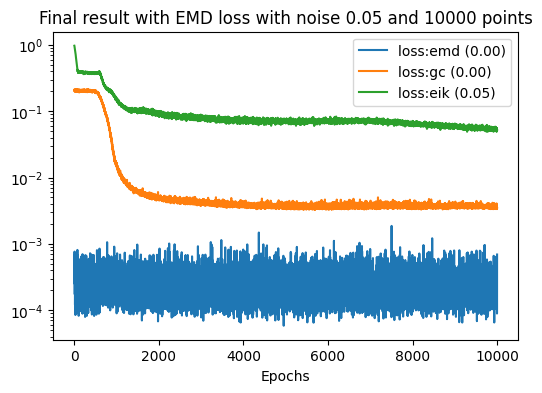

initialisation Xavier True fix_init False


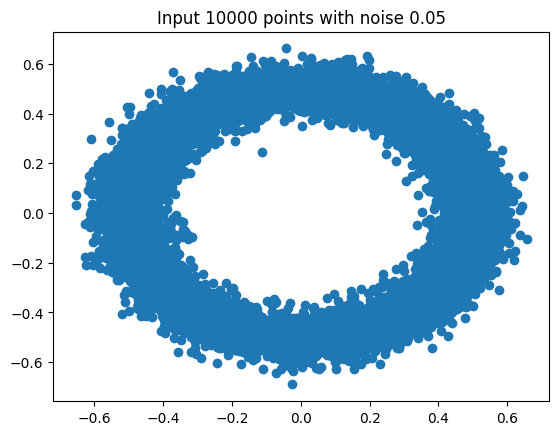

starting loss, lambda_pc=1, lambda_eik=0.001, lambda_hint=0, lambda_lse=0, lambda_gc=0.01, lambda_emd=0


lambda_emd is null


Training: 100%|██████████| 10000/10000 [01:54<00:00, 86.98it/s, loss=0.000154]


Optimizing NN took 114.97 s.
coords shape before adding t: torch.Size([40000, 2])
the sdf that will be displayed: tensor([[0.8081],
        [0.8002],
        [0.7922],
        ...,
        [0.7903],
        [0.7978],
        [0.8049]], device='cuda:0', grad_fn=<AddmmBackward0>)
keys gc [0.22943396866321564, 0.23111672699451447, 0.22069308161735535, 0.2243027240037918, 0.225931316614151, 0.22706995904445648, 0.23008157312870026, 0.225443035364151, 0.22308704257011414, 0.22415031492710114, 0.21705082058906555, 0.22493094205856323, 0.22807301580905914, 0.22404144704341888, 0.21367478370666504, 0.22440925240516663, 0.21785090863704681, 0.2253844439983368, 0.22055023908615112, 0.2197122871875763, 0.2210332453250885, 0.2079097032546997, 0.2214035987854004, 0.21628354489803314, 0.2168736308813095, 0.21347562968730927, 0.21280156075954437, 0.2110452950000763, 0.20489737391471863, 0.2152266800403595, 0.2176883965730667, 0.20858538150787354, 0.21123656630516052, 0.20947113633155823, 0.2112274020

<Figure size 640x480 with 0 Axes>

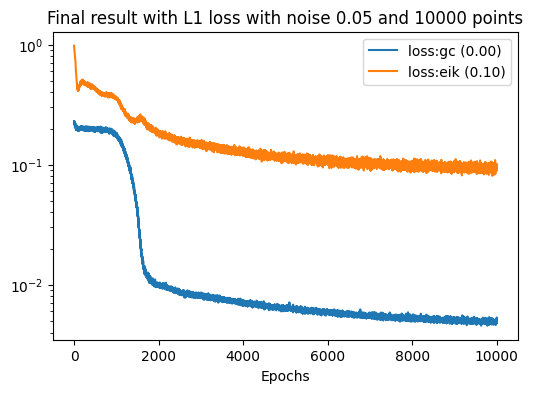

initialisation Xavier True fix_init False


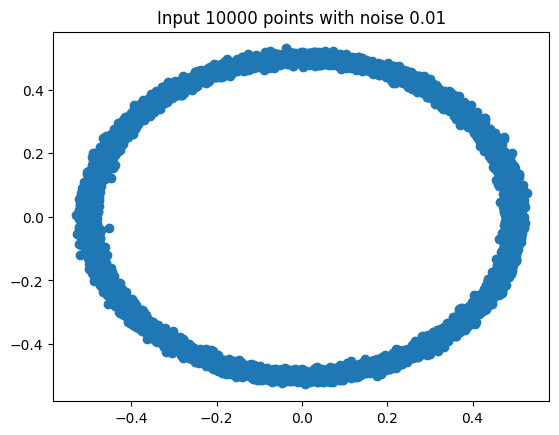

starting loss, lambda_pc=0, lambda_eik=0.001, lambda_hint=0, lambda_lse=0, lambda_gc=0.01, lambda_emd=1


lambda_pc is null


Training: 100%|██████████| 10000/10000 [05:54<00:00, 28.22it/s, loss=0.000186]


Optimizing NN took 354.33 s.
coords shape before adding t: torch.Size([40000, 2])
the sdf that will be displayed: tensor([[-0.9275],
        [-0.9194],
        [-0.9106],
        ...,
        [-0.9118],
        [-0.9209],
        [-0.9293]], device='cuda:0', grad_fn=<AddmmBackward0>)
keys emd [0.005696757230907679, 0.005586665123701096, 0.00459311343729496, 0.0040458193980157375, 0.003619004972279072, 0.003147321753203869, 0.0029923394322395325, 0.002608705312013626, 0.0026103220880031586, 0.0020821471698582172, 0.0019397861324250698, 0.0018152655102312565, 0.0014150391798466444, 0.001671444857493043, 0.001266856910660863, 0.0011663911864161491, 0.0013401044998317957, 0.001608460210263729, 0.0012099749874323606, 0.0008662710897624493, 0.0007461881032213569, 0.0006381607381626964, 0.0007981604430824518, 0.0008602514863014221, 0.0005548554472625256, 0.00047698174603283405, 0.0005354707827791572, 0.000749943545088172, 0.0005343216471374035, 0.0004069148562848568, 0.0005469446768984199, 0.

<Figure size 640x480 with 0 Axes>

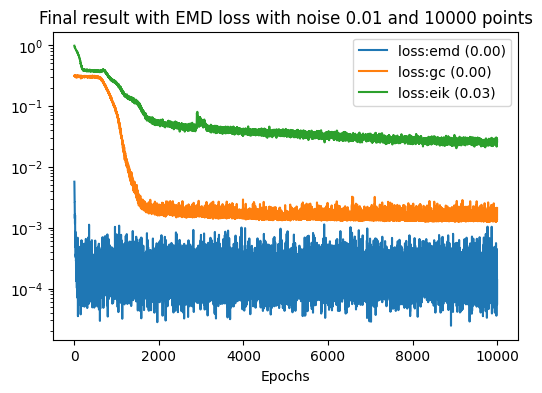

initialisation Xavier True fix_init False


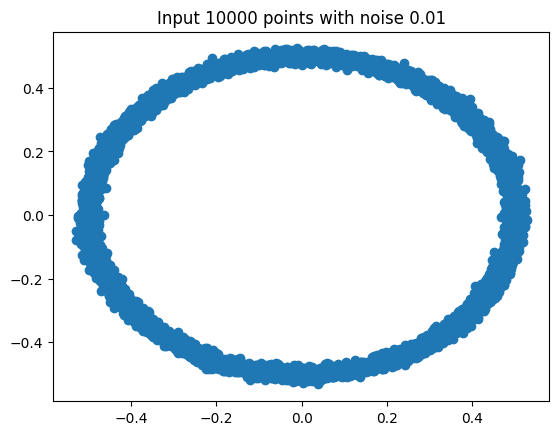

starting loss, lambda_pc=1, lambda_eik=0.001, lambda_hint=0, lambda_lse=0, lambda_gc=0.01, lambda_emd=0


lambda_emd is null


Training: 100%|██████████| 10000/10000 [01:55<00:00, 86.93it/s, loss=6.58e-5]


Optimizing NN took 115.03 s.
coords shape before adding t: torch.Size([40000, 2])
the sdf that will be displayed: tensor([[-0.9119],
        [-0.9060],
        [-0.8999],
        ...,
        [-0.8983],
        [-0.9060],
        [-0.9140]], device='cuda:0', grad_fn=<AddmmBackward0>)
keys gc [0.3041131794452667, 0.3027254045009613, 0.3080465495586395, 0.30728885531425476, 0.2995544672012329, 0.3055066764354706, 0.29802069067955017, 0.3109436631202698, 0.303698867559433, 0.30342793464660645, 0.3024975657463074, 0.30632922053337097, 0.3108670115470886, 0.3108656108379364, 0.3004201352596283, 0.297577828168869, 0.31190553307533264, 0.30435189604759216, 0.3066916763782501, 0.2940461039543152, 0.3141156733036041, 0.30288660526275635, 0.31075504422187805, 0.2966848909854889, 0.29909539222717285, 0.30083489418029785, 0.3005267381668091, 0.3006821572780609, 0.30203548073768616, 0.30303955078125, 0.30278676748275757, 0.30084896087646484, 0.3035585284233093, 0.3022892475128174, 0.303046226501464

<Figure size 640x480 with 0 Axes>

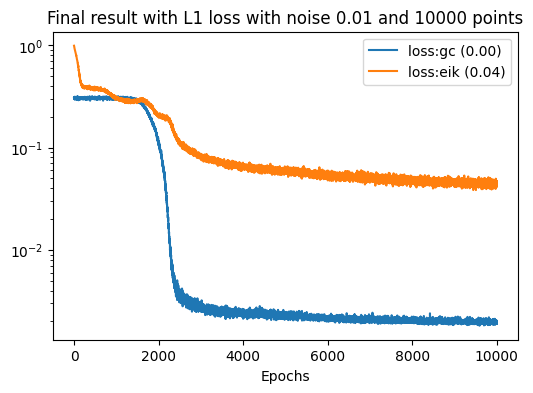

In [ ]:
#! with some help  
from src.models.tiny_cu import SDF_TCNN  
nb_data=100
noise=0.01
nb_data=10000
for noise in [0.1,0.05,0.01]:



    true_net = SDF_TCNN().to(device)
    optimizer = lambda model: torch.optim.Adam([
                {'name': 'encoding', 'params': model.encoder.parameters()},
                {'name': 'net', 'params': model.backbone.parameters(), 'weight_decay': 1e-6},
            ], lr=1e-4, betas=(0.9, 0.99), eps=1e-15)

    pc0, nc0, pts_hints0, gt_sdf_hints0, gt_grad_hints0, coords, sdf_coords = sphere_data(
        nb_data, nb_data #! was sth else before
    )

    optimizer = optimizer(true_net)
    lpc, leik, lh, llse = [], [], [], []
    lemd=[]
    lgc=[]  

    batch_size=2000,
    list_loss={"emd":[],"gc":[],"eik":[],"hint":[],"pc":[]}
    pc_t0 = pc0.clone().to(device)
    pc_t0=add_noise(pc_t0,sigma=noise)
    # pc_t0=add_noise_along_circle(pc_t0,scale=3)
    # plot the points
    plt.clf()
    plt.scatter(pc_t0.detach().cpu().numpy()[:, 0], pc_t0.detach().cpu().numpy()[:, 1])
    plt.title("Input {} points with noise {}".format(nb_data,noise))
    plt.show()
    plt.savefig("input_{}_{}.png".format(noise,nb_data))

    pts_hintst0 = pts_hints0.clone().to(device)
    # nepochs = 10000
    nepochs=10000
    pc_t0.requires_grad = True
    # nepochs=10
    optimize_nise_vf(
        net=true_net,
        pc0=pc_t0,
        # nc0=nc0,
        hints0=pts_hintst0,
        gtsdf0=gt_sdf_hints0,
        # vf=vf,
        # lpc=lpc,
        # leik=leik,
        # lh=lh,
        # llse=llse,
        # lemd=lemd,
        # lgc=lgc,
        
        lambda_pc=0,# 
        lambda_eik=0.001, # eikonal,
        lambda_hint=0, #0.01, # used but need ground truth,
        lambda_lse=0, # not used,
        lambda_gc=0.01, #geometric consistency,
        lambda_emd=1, # lambda EMD,
        batch_size=2000,
        nepochs=nepochs,
        plot_loss=False,
        follow_paper=False,
        list_loss=list_loss,
        optim=optimizer
    )
    # save it 
    # torch.save(true_net, "net_vf_128_3.net")
    plt.clf()
    filname= "result_EMD_{}_{}.png".format(noise,nb_data)

    display_result(true_net, resolution=200, figsize=(14, 5),title="Final result with EMD loss with noise {} and {} points".format(noise,nb_data),filename=filname)
    plt.clf()
    display_loss(list_loss,["pc"])
    plt.title("Final result with EMD loss with noise {} and {} points".format(noise,nb_data))

    plt.show()
    
    plt.clf()
    true_net = SDF_TCNN().to(device)
    optimizer = lambda model: torch.optim.Adam([
                {'name': 'encoding', 'params': model.encoder.parameters()},
                {'name': 'net', 'params': model.backbone.parameters(), 'weight_decay': 1e-6},
            ], lr=1e-4, betas=(0.9, 0.99), eps=1e-15)

    pc0, nc0, pts_hints0, gt_sdf_hints0, gt_grad_hints0, coords, sdf_coords = sphere_data(
        nb_data, nb_data #! was sth else before
    )

    optimizer = optimizer(true_net)
    lpc, leik, lh, llse = [], [], [], []
    lemd=[]
    lgc=[]  

    batch_size=2000,
    list_loss={"emd":[],"gc":[],"eik":[],"hint":[],"pc":[]}
    pc_t0 = pc0.clone().to(device)
    pc_t0=add_noise(pc_t0,sigma=noise)
    # pc_t0=add_noise_along_circle(pc_t0,scale=3)
    # plot the points
    plt.clf()
    plt.scatter(pc_t0.detach().cpu().numpy()[:, 0], pc_t0.detach().cpu().numpy()[:, 1])
    plt.title("Input {} points with noise {}".format(nb_data,noise))
    plt.show()
    plt.savefig("input_{}_{}.png".format(noise,nb_data))

    pts_hintst0 = pts_hints0.clone().to(device)
    # nepochs = 10000
    nepochs=10000
    pc_t0.requires_grad = True
    # nepochs=10
    optimize_nise_vf(
        net=true_net,
        pc0=pc_t0,
        # nc0=nc0,
        hints0=pts_hintst0,
        gtsdf0=gt_sdf_hints0,
        # vf=vf,
        # lpc=lpc,
        # leik=leik,
        # lh=lh,
        # llse=llse,
        # lemd=lemd,
        # lgc=lgc,
        
        lambda_pc=1,# 
        lambda_eik=0.001, # eikonal,
        lambda_hint=0, #0.01, # used but need ground truth,
        lambda_lse=0, # not used,
        lambda_gc=0.01, #geometric consistency,
        lambda_emd=0, # lambda EMD,
        batch_size=2000,
        nepochs=nepochs,
        plot_loss=False,
        follow_paper=False,
        list_loss=list_loss,
        optim=optimizer
    )
    # save it 
    # torch.save(true_net, "net_vf_128_3.net")
    plt.clf()
    filname= "result_L1_{}_{}.png".format(noise,nb_data)

    display_result(true_net, resolution=200, figsize=(14, 5),title="Final result with L1 loss with noise {} and {} points".format(noise,nb_data),filename=filname)
    plt.clf()
    display_loss(list_loss,["pc"])
    plt.title("Final result with L1 loss with noise {} and {} points".format(noise,nb_data))

    plt.show()

# Test 
Test with more weight on the noise?

initialisation Xavier True fix_init False


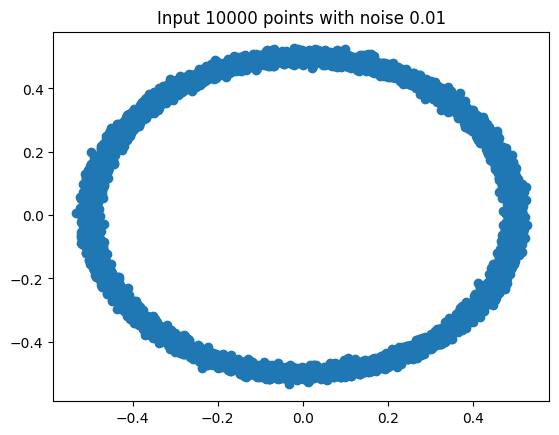

starting loss, lambda_pc=0, lambda_eik=0.001, lambda_hint=0, lambda_lse=0, lambda_gc=0.01, lambda_emd=2


lambda_pc is null


In [ ]:


#! 
nb_data=10000
noise=0.01


true_net = SDF_TCNN().to(device)
optimizer = lambda model: torch.optim.Adam([
            {'name': 'encoding', 'params': model.encoder.parameters()},
            {'name': 'net', 'params': model.backbone.parameters(), 'weight_decay': 1e-6},
        ], lr=1e-4, betas=(0.9, 0.99), eps=1e-15)

pc0, nc0, pts_hints0, gt_sdf_hints0, gt_grad_hints0, coords, sdf_coords = sphere_data(
    nb_data, nb_data #! was sth else before
)

optimizer = optimizer(true_net)
lpc, leik, lh, llse = [], [], [], []
lemd=[]
lgc=[]  

batch_size=2000,
list_loss={"emd":[],"gc":[],"eik":[],"hint":[],"pc":[]}
pc_t0 = pc0.clone().to(device)
pc_t0=add_noise(pc_t0,sigma=noise)
# pc_t0=add_noise_along_circle(pc_t0,scale=3)
# plot the points
plt.clf()
plt.scatter(pc_t0.detach().cpu().numpy()[:, 0], pc_t0.detach().cpu().numpy()[:, 1])
plt.title("Input {} points with noise {}".format(nb_data,noise))
plt.show()
plt.savefig("input_{}_{}.png".format(noise,nb_data))

pts_hintst0 = pts_hints0.clone().to(device)
# nepochs = 10000
nepochs=10000
pc_t0.requires_grad = True
# nepochs=10
optimize_nise_vf(
    net=true_net,
    pc0=pc_t0,
    # nc0=nc0,
    hints0=pts_hintst0,
    gtsdf0=gt_sdf_hints0,
    # vf=vf,
    # lpc=lpc,
    # leik=leik,
    # lh=lh,
    # llse=llse,
    # lemd=lemd,
    # lgc=lgc,
    
    lambda_pc=0,# 
    lambda_eik=0.001, # eikonal,
    lambda_hint=0, #0.01, # used but need ground truth,
    lambda_lse=0, # not used,
    lambda_gc=0.01, #geometric consistency,
    lambda_emd=2, # lambda EMD,
    batch_size=2000,
    nepochs=nepochs,
    plot_loss=True,
    follow_paper=False,
    list_loss=list_loss,
    optim=optimizer
)
# save it 
# torch.save(true_net, "net_vf_128_3.net")
plt.clf()
filname= "result_EMD_{}_{}.png".format(noise,nb_data)

display_result(true_net, resolution=200, figsize=(14, 5),title="Final result with EMD loss with noise {} and {} points".format(noise,nb_data))
plt.clf()
display_loss(list_loss,["pc"])
plt.title("Final result with EMD loss with noise {} and {} points".format(noise,nb_data))

